<a href="https://colab.research.google.com/github/AKIYAMA-Keito/Colab-repo/blob/main/AWP_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Step1 Tensorflowチュートリアル4から引用

version2


データセットを読み込んで正規化する．

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
random_index_train = np.array(range(len(x_train)))
np.random.shuffle(random_index_train)
x_train = x_train[random_index_train][:1000]
y_train = y_train[random_index_train][:1000]
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

データセットをシャッフルしてバッチ化する．

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).batch(1000)
test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)
).batch(1000)

CNNモデルを定義しインスタンスを取り出す．

In [4]:
class CNNModel(Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation = "relu")
        self.flatten = Flatten()
        self.d1 = Dense(128, activation = "relu")
        self.d2 = Dense(10)
    
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

model = CNNModel()

損失関数とoptmizerを選択する．

In [5]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam()

損失関数とoptimizerの尺度評価のための関数を導入する．

In [6]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

モデルを訓練するための関数train_stepを定義する．
予測値と正解ラベルの間の損失関数の勾配を最適化する．

In [7]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training = True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

モデルをテストするための関数test_stepを定義する．

In [8]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training = False)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

学習を実行してテストし，結果を出力する．

In [9]:
EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for train_images, train_labels in train_ds:
        train_step(train_images, train_labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Loss: 2.3102738857269287, Accuracy: 6.400000095367432, Test Loss: 1.9344654083251953, Test Accuracy: 50.91999816894531
Epoch 2, Loss: 1.9014227390289307, Accuracy: 56.69999694824219, Test Loss: 1.5126394033432007, Test Accuracy: 67.90999603271484
Epoch 3, Loss: 1.4684606790542603, Accuracy: 73.4000015258789, Test Loss: 1.1584216356277466, Test Accuracy: 77.61000061035156


## AWPのための関数

Step2

In [10]:
# @tf.function
def adversary(dataset, additive_weights, eps1 = 1, eta1 = 0.1, iterate_num = 5):
    weights = model.get_weights()
    new_weights = []
    for w, v in zip(weights, additive_weights):
      new_weights.append(w + v)
    model.set_weights(new_weights)

    adversarial_image_list = []
    for (images, labels) in dataset:
      for (image, label) in zip(images, labels):
        image = tf.Variable([image])

        initial_noise = 2 * eps1 * np.random.rand() - eps1
        image_dashed = tf.add(image, initial_noise)

        # この書き方でも，initial_noiseが一様に入ってしまっている．
        # tf.Variableで1次元追加しているから，より内側のループを作らないといけないよ
        # image_dashed_list = []
        # for image_0 in image:
        #   for image_h in image_0:
        #     for image_v in image_h:
        #       for image_pixel in image_v:
        #         initial_noise = 2 * eps1 * np.random.rand() - eps1
        #         image_pixel_dashed = tf.add(image_pixel, initial_noise)
        # image_dashed_list.append(image_pixel_dashed)
        # # image_dashed = np.array(image_dashed_list)
        # image_dashed = tf.convert_to_tensor(image_dashed_list)
        # print(image_dashed.numpy())

        for j in range(iterate_num):
          with tf.GradientTape() as tape:
            tape.watch(image_dashed)
            prediction = model(image_dashed, training = True)
            loss = loss_object(label, prediction)
          gradients = tape.gradient(loss, image_dashed)
          image_med = tf.add(image_dashed, tf.multiply(eta1, gradients))
          difference = tf.subtract(image_med, image)
          if tf.norm(difference) <= eps1:
            image_dashed = image_med 
          else:
            image_dashed = difference
            image_dashed = tf.multiply(image_dashed, eps1)
            image_dashed = tf.divide(image_dashed, tf.norm(difference))
            image_dashed = tf.add(image_dashed, image)
        adversarial_image_list.append(image_dashed[0])
        adversarial_image = np.array(adversarial_image_list)

    return adversarial_image

Step3

In [11]:
def calculate_loss(dataset, batch_size = 1000):
  batch_size = 1000
  loss_sum = 0.0
  for (images, labels) in dataset:
    predictions = model(images, training = True)
    loss = loss_object(labels, predictions)
    loss_sum_batch = loss * batch_size
    loss_sum = tf.add(loss_sum_batch, loss_sum)
  average_loss = tf.divide(loss_sum, 1000)
  return average_loss

Step4

In [12]:
def calculate_weights_norm(weights):
  w_flat = np.ndarray([])
  for w in weights:
    w_reshape = tf.reshape(w, [-1])
    w_flat = np.hstack([w_flat, w_reshape])
  w_fro = np.linalg.norm(w_flat)
  return w_fro

In [13]:
def flatness(dataset, weights, v_fixed, eps2 = 1, eta2 = 0.1, batch_size = 1000, iterate_num = 5):
  # vの初期値を，step2で固定したvに設定する．
  v_updated = v_fixed

  for i in range(iterate_num):

    # 重みをw + (現在の)vに設定する　　ここから
    current_weights = []
    for layer_weights, v in zip(weights, v_updated):
      current_layer_weight = tf.add(layer_weights, v)
      current_weights.append(current_layer_weight)
    model.set_weights(current_weights)
    # 重みをw + (現在の)vに設定する　　ここまで

    # gradientの計算　　ここから
    with tf.GradientTape() as tape:
      loss = calculate_loss(dataset)
      # loss = tf.multiply(-1.0, calculate_loss(dataset))
    gradients = tape.gradient(loss, model.trainable_variables)
    #　計算できているし，悪い値ではない．
    # gradientの計算　　ここまで

    # gradientのノルムの計算　　ここから
    gradients_flat = []
    for g in gradients:
      g_reshape = tf.reshape(g, [-1])
      gradients_flat = np.hstack([gradients_flat, g_reshape])
    gradients_norm = np.linalg.norm(gradients_flat)
    # ループを経るごとに値が大きくなり過ぎている？
    # gradientのノルムの計算　　ここまで

    # 勾配降下の実行　　ここから
    v_difference = []
    for g, v in zip(gradients, v_updated):
      g = tf.divide(g, gradients_norm)
      g = tf.multiply(g, calculate_weights_norm(weights))
      g = tf.multiply(eta2, g)
      v_med = tf.add(v, g)
    # 勾配降下の実行　　ここまで

    # (現在の)vと(元の重み)wの差分と，　そのノルムを計算　　ここから
      v_difference.append(v_med)
    v_difference_flat = np.ndarray([])
    for v_flat in v_difference:
      v_flat_reshape = tf.reshape(v_flat, [-1])
      v_difference_flat = np.hstack([v_difference_flat, v_flat_reshape])
    v_difference_norm = np.linalg.norm(v_difference_flat)
    # (現在の)vと(元の重み)wの差分と，　そのノルムを計算　　ここまで

    # 射影の実行　　ここから
    if v_difference_norm <= eps2:
      v_hat = v_med 
    else:
      v_hat = v_difference
      for v_hat_med in v_hat:
        v_hat_med = tf.multiply(v_hat_med, eps2)
        v_hat_med = tf.divide(v_hat_med, v_difference_norm)
    v_updated = v_hat
    # 計算できているし，悪い値ではない．
    # 射影の実行　　ここまで

  return v_updated

Step5

In [14]:
def update(dataset, weights, v_updated, eta3 = 1):

  # 重みをw + (step4で決めた)vに設定する　　ここから
  current_weights = []
  for layer_weights, v in zip(weights, v_updated):
    current_layer_weight = tf.add(layer_weights, v)
    current_weights.append(current_layer_weight)
  model.set_weights(current_weights)
  # 計算できている．
  # 重みをw + (step4で決めた)vに設定する　　ここまで

  # gradientの計算　　ここから
  with tf.GradientTape() as tape:
    loss = calculate_loss(dataset)
  gradients = tape.gradient(loss, model.trainable_variables)
  # 計算できているが，値が大きい．
  # gradientの計算　　ここまで

  # 勾配降下の実行　　ここから
  w_hat = []
  for wu, g in zip(weights, gradients):
    g_med = tf.multiply(eta3, g)
    wu = tf.subtract(wu, g_med)
    w_hat.append(wu)
  weights_updated = w_hat
  # 勾配降下の実行　　ここまで
  return weights_updated

## AWPのアルゴリズム

In [15]:
def AWP_execution(epochs):
  # 重みをシフトして再設定する　ここから
  ordinary_weights = model.get_weights()
  v_array = []
  for w in ordinary_weights:
    v = 0.00002 * np.random.rand() - 0.00001
    v_array.append(tf.fill(w.shape, v))
  
  # 重みをシフトして再設定する　ここまで

  # 敵対的データセットの生成　ここから
  x_adversarial = adversary(train_ds, v_array)
  adversarial_ds = tf.data.Dataset.from_tensor_slices(
      (x_adversarial, y_train)
  ).batch(1000)
  # 敵対的データセットの生成　ここまで

  # ノイズとノイズ入りデータの可視化　ここから
  # plt.imshow(np.squeeze(x_adversarial[0] - x_train[0]))
  # plt.show()
  # print(y_train[0])
  # plt.imshow(np.squeeze(x_adversarial[0]))
  # plt.show()
  # print(y_train[0])
  # ノイズとノイズ入りデータの可視化　ここまで

  # 平坦度vの更新　ここから
  new_v = flatness(adversarial_ds, ordinary_weights, v_array)
  # 平坦度vの更新　ここまで

  # 重みの更新　ここから
  new_weights = update(adversarial_ds, ordinary_weights, new_v)
  model.set_weights(new_weights)
  # 重みの更新　ここまで

  # テストの実行　ここから
  test_loss.reset_states()
  test_accuracy.reset_states()
  for test_images, test_labels in test_ds:
      test_step(test_images, test_labels)
  # テストの実行　ここまで

  return [test_loss.result(), test_accuracy.result() * 100]
  # print(
  #       f'Epoch {epoch + 1}, '
  #       f'Test Loss: {test_loss.result()}, '
  #       f'Test Accuracy: {test_accuracy.result() * 100}'
  #   )

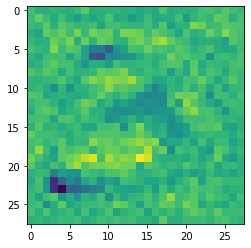

3


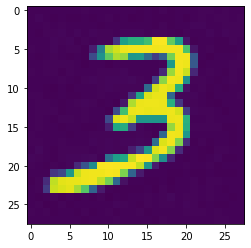

3
Epoch 1, Test Loss: 2.0033860206604004, Test Accuracy: 49.709999084472656


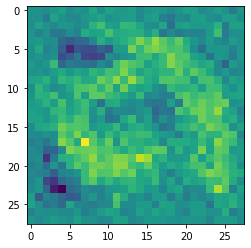

3


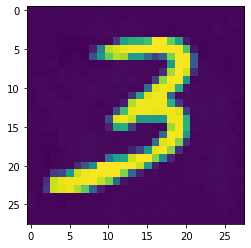

3
Epoch 2, Test Loss: nan, Test Accuracy: 9.800000190734863


/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


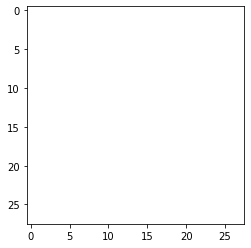

3


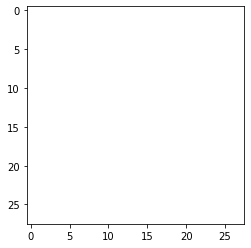

3
Epoch 3, Test Loss: nan, Test Accuracy: 9.800000190734863


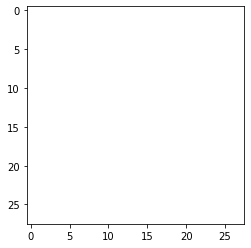

3


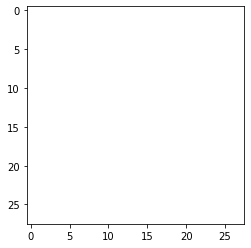

3
Epoch 4, Test Loss: nan, Test Accuracy: 9.800000190734863


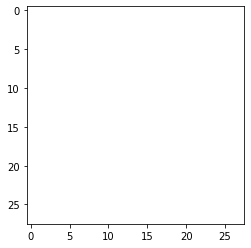

3


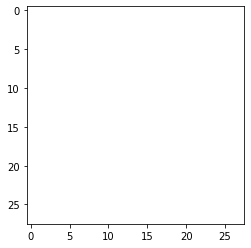

3
Epoch 5, Test Loss: nan, Test Accuracy: 9.800000190734863


In [16]:
epochs = 5
for i in range(epochs):
  AWP_result = AWP_execution(epochs)
  print(f'Epoch {i + 1}, ' f'Test Loss: {AWP_result[0]}, ' f'Test Accuracy: {AWP_result[1]}')

### 重みをシフトして再設定

In [17]:
# weights = model.get_weights()
# ordinary_weights = weights
# v_array = []
# for w in weights:
#   v = 0.00002 * np.random.rand() - 0.00001
#   v_array.append(tf.fill(w.shape, v))

### 敵対的データの生成

In [18]:
# x_adversarial = adversary(train_ds, v_array)

In [19]:
# adversarial_ds = tf.data.Dataset.from_tensor_slices(
#     (x_adversarial, y_train)
# ).batch(1000)

### ノイズとノイズ入り画像の可視化

In [20]:
# plt.imshow(np.squeeze(x_adversarial[0] - x_train[0]))
# plt.show()
# print(y_train[0])

In [21]:
# plt.imshow(np.squeeze(x_adversarial[0]))
# plt.show()
# print(y_train[0])

### 重みのフロベニウスノルムの計算

In [22]:
# value1 = calculate_weights_norm(ordinary_weights)
# print(value1)

### 平坦度vの更新

In [23]:
# new_v = flatness(adversarial_ds, ordinary_weights, v_array)

### 重みの更新

In [24]:
# new_weights = update(adversarial_ds, ordinary_weights, new_v)
# print(new_weights)
# model.set_weights(new_weights)
# ordinary_weights = model.get_weights()

再テストの実行

In [25]:
# EPOCHS = 5

# for epoch in range(EPOCHS):
#     test_loss.reset_states()
#     test_accuracy.reset_states()

#     for test_images, test_labels in test_ds:
#         test_step(test_images, test_labels)
    
#     print(
#         f'Epoch {epoch + 1}, '
#         f'Test Loss: {test_loss.result()}, '
#         f'Test Accuracy: {test_accuracy.result() * 100}'
#     )